In [69]:
import os
import torch
import torchvision.models as models
import torch.nn as nn
# from deepproblog.dataset import Dataset, DataLoader, QueryDataset
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as TorchDataset
from deepproblog.dataset import Dataset as DPLDataset
from problog.logic import Term, Constant, Var, list2term
from deepproblog.dataset import ImageDataset
from deepproblog.evaluate import get_confusion_matrix
from torch.amp.autocast_mode import autocast
from torchvision import models, transforms, datasets
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from deepproblog.dataset import DataLoader as DPLDataLoader

import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
from deepproblog.utils.stop_condition import EpochStop
from deepproblog.optimizer import SGD

from deepproblog.model import Model
from deepproblog.network import Network
from deepproblog.engines import ExactEngine
from deepproblog.query import Query
from deepproblog.train import train_model
import torch.nn as nn
import torch.nn.functional as F

from torch.amp.grad_scaler import GradScaler
from torch.amp.autocast_mode import autocast

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import glob
from retinaface import RetinaFace
import csv

In [70]:
# GLOBAL VARS
dataset_size = 19262
lr_faces = 5e-6
lr_scenes = 1e-4
lr_model = 1e-1
batch_size = 32
log_iter = 2
epochs = 30
load_model = False

In [71]:
# Directories
script_dir = os.getcwd()
print("script_dir:", script_dir)
base_dir = os.path.dirname(os.path.dirname(script_dir))
print("base_dir:", base_dir)
prolog_dir = os.path.join(base_dir, "prolog")
data_dir = os.path.join(base_dir, "data")
print("data_dir:", data_dir)
findingemo_dir = os.path.join(data_dir, "FindingEmo_Images")
print("findingemo_dir:", findingemo_dir)
prolog_dir = os.path.join(base_dir, "code", "prolog")
print("prolog_dir:", prolog_dir)
model_dir = os.path.join(base_dir, "code", "models")
print("model_dir:", model_dir)
cropped_faces_dir = os.path.join(findingemo_dir, "faces")
print("cropped_faces_dir:", cropped_faces_dir)

script_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\notebooks
base_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition
data_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data
findingemo_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data\FindingEmo_Images
prolog_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\prolog
model_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\models
cropped_faces_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data\FindingEmo_Images\faces


In [72]:
# # try to read all the images to see if any are missing or corrupted
# df = pd.read_csv(os.path.join(findingemo_dir, "annotations_single.ann"))

# # Delete the columns: "user" and "index" and "datetime"
# if "user" in df.columns and "index" in df.columns and "datetime" in df.columns:
#     df = df.drop(columns=["user", "index", "datetime"])

# # remove leading slash from image_path
# if df["image_path"].iloc[0].startswith("/"):
#     df["image_path"] = df["image_path"].str.lstrip("/")

# # in the dataframe image_path column, change all the occurences of 'lmertens' to 'anon'
# df["image_path"] = df["image_path"].str.replace("lmertens", "anon", regex=False)
# # change the occurences of *, : ? in the image_path to _
# df["image_path"] = df["image_path"].str.replace("*", "_", regex=False)
# df["image_path"] = df["image_path"].str.replace(":", "_", regex=False)
# df["image_path"] = df["image_path"].str.replace("?", "_", regex=False)

# corrupted_indices = []
# for idx, row in df.iterrows():
#     if idx % 100 == 0:
#         print(f"Checking image {idx}/{len(df)}")
#     img_path = os.path.join(findingemo_dir, row['image_path'])
#     try:
#         img = cv2.imread(img_path)
#         if img is None:
#             print(f"Image at index {idx} could not be read: {img_path}")
#             corrupted_indices.append(idx)
#     except Exception as e:
#         print(f"Error reading image at index {idx}: {img_path}. Error: {e}")
# print(f"Total corrupted/missing images: {len(corrupted_indices)}")
# print("Corrupted indices:", corrupted_indices)
# # Remove corrupted entries from dataframe
# df = df.drop(index=corrupted_indices).reset_index(drop=True)
# # save the cleaned dataframe as pickle
# df.to_pickle("clean_findingemo.pkl")

df = pd.read_pickle(os.path.join(script_dir, "clean_findingemo.pkl"))
print("Dataframe loaded. Number of entries:", len(df))

Dataframe loaded. Number of entries: 25867


In [73]:
# corrupted_indices = []
# for idx, row in df.iterrows():
#     if idx % 100 == 0:
#         print(f"Checking image {idx}/{len(df)}")
#     img_path = os.path.join(findingemo_dir, row['image_path'])
#     try:
#         img = cv2.imread(img_path)
#         if img is None:
#             print(f"Image at index {idx} could not be read: {img_path}")
#             corrupted_indices.append(idx)
#     except Exception as e:
#         print(f"Error reading image at index {idx}: {img_path}. Error: {e}")
# print(f"Total corrupted/missing images: {len(corrupted_indices)}")
# print("Corrupted indices:", corrupted_indices)

In [74]:
# set device, move models and maps, set eval mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [75]:
df.head()

,image_path,tags,age,valence,arousal,emotion,dec_factors,ambiguity
0,Run_2/Loving toddlers sports/haiti-kids.jpg,Undefined,Children,0,2,Trust,"BodyLanguage,FacialExpression",0
1,Run_2/Frustrated forty-something office/team-w...,Undefined,Young Adults,0,2,Interest,FacialExpression,0
2,Run_1/Violent youth festival/1042373588.jpg,Undefined,Young Adults,2,2,Interest,BodyLanguage,3
3,Run_2/Remorseful toddlers court of law/dcfs-co...,Undefined,Adults,1,2,Interest,"BodyLanguage,FacialExpression",4
4,Run_2/Shame elderly sports/3364887-46.jpg,Undefined,Adults,0,3,Apprehension,ConflictCtxtPerson,0


In [76]:
len(df)

25867

In [77]:
if dataset_size is not None:
    df = df.iloc[:dataset_size]

In [78]:
df.tail()

,image_path,tags,age,valence,arousal,emotion,dec_factors,ambiguity
19257,Run_2/Mocking students fighting/facebook.jpg,Undefined,"Youth,Young Adults,Adults",3,3,Acceptance,FacialExpression,0
19258,Run_2/Frustrated seniors shopping/nn_emc_vacci...,Undefined,"Adults,Seniors",0,0,Trust,Neutral,0
19259,Run_2/Appreciative soldiers rally/14158912317_...,Undefined,Young Adults,0,1,Interest,Neutral,1
19260,Run_2/Awe students mall/img_5112.jpg,Undefined,"Youth,Young Adults",2,0,Joy,Staging,0
19261,Run_2/Furious twenty-something holding/22d6ea1...,"NoInteraction,NA","Young Adults,Adults",0,3,Admiration,Staging,3


In [79]:
EMOTION_SETS = [["Serenity", "Joy", "Ecstasy"],
                    ["Acceptance", "Trust", "Admiration"],
                    ["Apprehension", "Fear", "Terror"],
                    ["Distraction", "Surprise", "Amazement"],
                    ["Pensiveness", "Sadness", "Grief"],
                    ["Boredom", "Disgust", "Loathing"],
                    ["Annoyance", "Anger", "Rage"],
                    ["Interest", "Anticipation", "Vigilance"]]
                
def emo_8_mapping(e):
    for leaf in EMOTION_SETS:
        if e in leaf:
            return leaf[1]

In [80]:
# I'm going to simplify the emotions to happy, sad and neutral first
df['emo8'] = df['emotion'].apply(emo_8_mapping).str.lower()

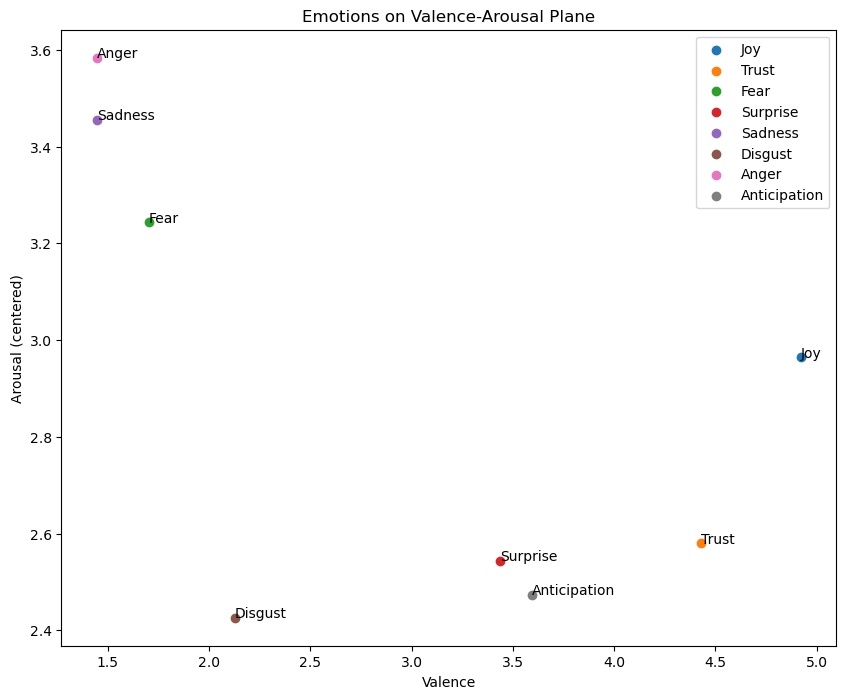

In [81]:
# Print the average valence and arousal value for each emo8 class
# print the emotions on a 2D valence-arousal plane
plt.figure(figsize=(10, 8))
for emo in [leaf[1] for leaf in EMOTION_SETS]:
    subset = df[df['emo8'] == emo.lower()]
    avg_valence = subset['valence'].mean() + 3
    avg_arousal = subset['arousal'].mean()
    plt.scatter(avg_valence, avg_arousal, label=emo)
    plt.text(avg_valence, avg_arousal, emo)
plt.xlabel('Valence')
plt.ylabel('Arousal (centered)')
plt.title('Emotions on Valence-Arousal Plane')
plt.legend()
plt.show()

In [82]:
df.head()

,image_path,tags,age,valence,arousal,emotion,dec_factors,ambiguity,emo8
0,Run_2/Loving toddlers sports/haiti-kids.jpg,Undefined,Children,0,2,Trust,"BodyLanguage,FacialExpression",0,trust
1,Run_2/Frustrated forty-something office/team-w...,Undefined,Young Adults,0,2,Interest,FacialExpression,0,anticipation
2,Run_1/Violent youth festival/1042373588.jpg,Undefined,Young Adults,2,2,Interest,BodyLanguage,3,anticipation
3,Run_2/Remorseful toddlers court of law/dcfs-co...,Undefined,Adults,1,2,Interest,"BodyLanguage,FacialExpression",4,anticipation
4,Run_2/Shame elderly sports/3364887-46.jpg,Undefined,Adults,0,3,Apprehension,ConflictCtxtPerson,0,fear


In [83]:
# Load category names
scene_categories_path = os.path.join(data_dir, "places365/categories_places365.txt")
with open(scene_categories_path) as f:
    scene_categories = [line.strip().split(' ')[0][3:] for line in f]
    # If there is a / in the category name, replace it with _
    scene_categories = [cat.replace('/', '_') for cat in scene_categories]
print("Length of scene categories:", len(scene_categories))  # Should be 365

Length of scene categories: 365


In [84]:
# get the counts of the labels of emo8
df['emo8'].value_counts()

emo8
joy             5254
anticipation    4450
trust           2695
sadness         1920
fear            1761
anger           1748
disgust          772
surprise         662
Name: count, dtype: int64

In [85]:
if dataset_size is not None:
    N = dataset_size
else:
    N = len(df)
indices = list(range(N))

train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)
print("Train indices length:", len(train_indices))
print("Test indices length:", len(test_indices))

Train indices length: 15409
Test indices length: 3853


In [86]:
print(torch.cuda.is_available())
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# let cuDNN pick the fastest kernels for this image size
torch.backends.cudnn.benchmark = True

True


In [87]:
from transformers import AutoImageProcessor, AutoModelForImageClassification, AutoConfig


emotion_transform = AutoImageProcessor.from_pretrained("trpakov/vit-face-expression", use_fast=True)
face_model_base = AutoModelForImageClassification.from_pretrained("trpakov/vit-face-expression")

config = AutoConfig.from_pretrained("trpakov/vit-face-expression")
print(config.id2label)

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


In [88]:
class FacesDataset(ImageDataset):
    def __init__(self, indices):
        super().__init__(os.path.join(findingemo_dir, "faces"), extension="jpg", transform=emotion_transform)
        self.indices = indices
    
    def __getitem__(self, i):
        if isinstance(i, tuple):
            i = tuple(int(x.value) if isinstance(x, Constant) else x for x in i)
        
        tensor = super().__getitem__("img_{}_face_{}".format(*i))
        return tensor['pixel_values'][0]
    
    def __len__(self):
        return len(self.indices)
    
    def to_query(self, i):
        pass
    
train_faces_dataset = FacesDataset(train_indices)
test_faces_dataset = FacesDataset(test_indices)

In [89]:
class FaceNet(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model

    def forward(self, x):
        if isinstance(x, list):
            x = torch.stack(x)

        x = x.to(next(self.parameters()).device)
        outputs = self.base_model(x)
        logits = outputs.logits
        probs = F.softmax(logits, dim=1)
        return probs
    
face_model = FaceNet(face_model_base)
face_model.to(DEVICE)
print("Face model initialized")

Face model initialized


In [90]:
# Freeze embeddings
for param in face_model_base.vit.embeddings.parameters():
    param.requires_grad = False

# Freeze encoder layers 0–9
for layer in face_model_base.vit.encoder.layer[:10]:
    for param in layer.parameters():
        param.requires_grad = False

# UNFREEZE encoder layers 10 and 11
for layer in face_model_base.vit.encoder.layer[10:]:
    for param in layer.parameters():
        param.requires_grad = True

# Freeze final layernorm
for param in face_model_base.vit.layernorm.parameters():
    param.requires_grad = True   

# Train classifier head
for param in face_model_base.classifier.parameters():
    param.requires_grad = True

trainable = [name for name, p in face_model.named_parameters() if p.requires_grad]
print("Trainable parameters:", trainable)

Trainable parameters: ['base_model.vit.encoder.layer.10.attention.attention.query.weight', 'base_model.vit.encoder.layer.10.attention.attention.query.bias', 'base_model.vit.encoder.layer.10.attention.attention.key.weight', 'base_model.vit.encoder.layer.10.attention.attention.key.bias', 'base_model.vit.encoder.layer.10.attention.attention.value.weight', 'base_model.vit.encoder.layer.10.attention.attention.value.bias', 'base_model.vit.encoder.layer.10.attention.output.dense.weight', 'base_model.vit.encoder.layer.10.attention.output.dense.bias', 'base_model.vit.encoder.layer.10.intermediate.dense.weight', 'base_model.vit.encoder.layer.10.intermediate.dense.bias', 'base_model.vit.encoder.layer.10.output.dense.weight', 'base_model.vit.encoder.layer.10.output.dense.bias', 'base_model.vit.encoder.layer.10.layernorm_before.weight', 'base_model.vit.encoder.layer.10.layernorm_before.bias', 'base_model.vit.encoder.layer.10.layernorm_after.weight', 'base_model.vit.encoder.layer.10.layernorm_after.

In [91]:
face_network = Network(face_model, "face_model", batching=True)
face_network.optimizer = torch.optim.Adam(face_model.parameters(), lr=lr_faces)

In [92]:
scene_processor = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load pretrained Places365 ResNet18
scene_model_base = models.resnet18(num_classes=365)
weights_url = "http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar"
checkpoint = torch.hub.load_state_dict_from_url(weights_url, map_location="cpu")
state_dict = {k.replace("module.", ""): v for k, v in checkpoint["state_dict"].items()}
scene_model_base.load_state_dict(state_dict)

print("Loaded pretrained models")

Loaded pretrained models


In [93]:
from abc import ABC, abstractmethod
from pathlib import Path

class ImageDatasetExtension(DPLDataset, ABC):
    def __init__(self, root, extension="png", transform=None):
        super().__init__()
        self.root = Path(root)
        self.transform = transform
        self.extension = extension

    def __getitem__(self, index, extension=None):
        if type(index) is tuple:
            index = index[0]
        if extension is None:
            extension = self.extension
        p = self.root / "{}.{}".format(index, extension)
        with open(p, "rb") as f:
            img = Image.open(f)
            img = img.convert("RGB")
            if self.transform is not None:
                img = self.transform(img)
        return img

In [94]:
class SceneDataset(ImageDatasetExtension):
    def __init__(self, indices):
        super().__init__(os.path.join(findingemo_dir), extension="jpg", transform=scene_processor)
        self.indices = indices

    def __getitem__(self, i):
        if isinstance(i, tuple):
            i = tuple(int(x.value) if isinstance(x, Constant) else x for x in i)
        img_path = df.loc[i]['image_path']
        extension = img_path.rsplit('.', 1)[1]
        img_path_no_ext = img_path.rsplit('.', 1)[0]
        tensor = super().__getitem__(img_path_no_ext, extension = extension)
        return tensor
    
    def __len__(self):
        return len(self.indices)
    
    def to_query(self, i):
        pass

train_scenes_dataset = SceneDataset(train_indices)
test_scenes_dataset = SceneDataset(test_indices)

In [95]:
# def calculate_places_priors(threshold = 0.10, indices = train_indices):
#     scene_dict = {scene_name: [] for scene_name in scene_categories}
#     for sample_idx in tqdm(indices, desc=f"Calculating priors over {len(indices)} samples"):
#         scene_tensor = train_scenes_dataset[(sample_idx,)]
#         row = df.loc[sample_idx]
#         valence = row['valence'] + 3
#         arousal = row['arousal']
#         with torch.no_grad():
#             mapped_output = scene_model_base(scene_tensor.unsqueeze(0).to(DEVICE))[0]
#             mapped_softmax = torch.softmax(mapped_output, dim=0)

#         top3_scenes = torch.topk(mapped_softmax, 3)
        
#         # Now extract the scene names and probabilities
#         for prob, idx in zip(top3_scenes.values.cpu(), top3_scenes.indices.cpu()):
#             scene_name = scene_categories[idx.item()]
#             prob_value = prob.item()
#             if prob_value > threshold:
#                 scene_dict[scene_name].append((valence, arousal))

#     # Take the average of valence and arousal for each scene
#     scene_priors = {}
#     for scene_name, va_list in scene_dict.items():
#         if len(va_list) > 0:
#             nr_samples = len(va_list)
#             avg_valence = sum([va[0] for va in va_list]) / nr_samples
#             avg_arousal = sum([va[1] for va in va_list]) / nr_samples
#             scene_priors[scene_name] = (avg_valence, avg_arousal, nr_samples)
#         else:
#             scene_priors[scene_name] = (None, None, 0)

#     return scene_priors

# scene_priors = calculate_places_priors(threshold=0.10, indices=train_indices)

In [96]:
# from sklearn.cluster import KMeans
# from sklearn.preprocessing import StandardScaler
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# def cluster_places_categories(scene_priors, n_clusters=10):
#     # Filter scenes with sufficient samples and valid data
#     valid_scenes = []
#     features = []
#     weights = []
    
#     for scene_name, (valence, arousal, nr_samples) in tqdm(scene_priors.items(), desc="Filtering scenes"):
#         if valence is not None and arousal is not None:
#             valid_scenes.append(scene_name)
#             features.append([valence, arousal])
#             weights.append(nr_samples)
    
#     features = np.array(features)
#     weights = np.array(weights)
    
#     print(f"Valid scenes: {len(valid_scenes)}/{len(scene_priors)}")
#     print(f"Total samples: {weights.sum()}")
    
#     # Standardize features for clustering
#     scaler = StandardScaler()
#     features_scaled = scaler.fit_transform(features)
    
#     # Perform weighted K-means clustering
#     kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    
#     # Weight samples by duplicating based on nr_samples (approximate weighting)
#     # For true weighting, we sample proportionally
#     max_weight = int(weights.max())
#     weighted_features = []
#     weighted_indices = []
    
#     for i, w in enumerate(weights):
#         # Sample proportionally (normalize weights to reasonable range)
#         n_copies = max(1, int(w / max_weight * 100))
#         weighted_features.extend([features_scaled[i]] * n_copies)
#         weighted_indices.extend([i] * n_copies)
    
#     weighted_features = np.array(weighted_features)
    
#     # Fit clustering
#     kmeans.fit(weighted_features)
    
#     # Get cluster labels for original scenes (use most common label from weighted copies)
#     cluster_labels = {}
#     for i, scene_name in enumerate(valid_scenes):
#         # Find all copies of this scene in weighted data
#         copies_labels = [kmeans.labels_[j] for j, idx in enumerate(weighted_indices) if idx == i]
#         # Take most common label
#         cluster_labels[scene_name] = max(set(copies_labels), key=copies_labels.count)
    
#     # Transform cluster centers back to original space
#     cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
    
#     return cluster_labels, cluster_centers, features, valid_scenes, weights

# # Run clustering
# cluster_labels, cluster_centers, scene_features, valid_scenes, scene_weights = cluster_places_categories(
#     scene_priors, 
#     n_clusters=10)

# # Print cluster statistics
# print("\nCluster Statistics:")
# for cluster_id in range(len(cluster_centers)):
#     scenes_in_cluster = [s for s, c in cluster_labels.items() if c == cluster_id]
#     total_samples = sum(scene_priors[s][2] for s in scenes_in_cluster)
#     avg_valence = cluster_centers[cluster_id][0]
#     avg_arousal = cluster_centers[cluster_id][1]
#     print(f"Cluster {cluster_id}: {len(scenes_in_cluster)} scenes, {total_samples} samples")
#     print(f"  Center: Valence={avg_valence:.2f}, Arousal={avg_arousal:.2f}")
#     print()

In [97]:
# # Visualize clusters
# import matplotlib.pyplot as plt
# import matplotlib as mpl
# import matplotlib.patheffects
# def visualize_clusters_2d(cluster_labels, cluster_centers, scene_features, valid_scenes, scene_weights, scene_priors):
#     """2D visualization of clusters on valence-arousal plane with cluster ID labels on each point."""
#     plt.figure(figsize=(14, 10))
    
#     # Colors for each cluster
#     colors = plt.cm.tab20(np.linspace(0, 1, len(cluster_centers)))
    
#     for i, scene_name in enumerate(valid_scenes):
#         cluster_id = cluster_labels[scene_name]
#         valence, arousal = scene_features[i]
#         size = np.log1p(scene_weights[i]) * 20
        
#         # Scatter point
#         plt.scatter(valence, arousal, 
#                     c=[colors[cluster_id]], 
#                     s=size, 
#                     alpha=0.75, 
#                     edgecolors='black', 
#                     linewidth=0.5)
        
#         # Add cluster ID text next to the point
#         plt.text(valence, arousal, str(cluster_id),
#                  fontsize=8, 
#                  ha='center', va='center',
#                  color='white',
#                  path_effects=[
#                      mpl.patheffects.Stroke(linewidth=1.5, foreground='black'),
#                      mpl.patheffects.Normal()
#                  ])
    
#     # Plot cluster centers
#     plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], 
#                 c='red', s=300, marker='X', edgecolors='black', linewidth=2, 
#                 label='Cluster Centers', zorder=5)
    
#     # Annotate cluster centers
#     for i, (v, a) in enumerate(cluster_centers):
#         plt.annotate(f'C{i}', (v, a), fontsize=14, fontweight='bold', 
#                      ha='left', va='center', color='white',
#                      path_effects=[
#                          mpl.patheffects.Stroke(linewidth=2, foreground='black'),
#                          mpl.patheffects.Normal()
#                      ])
    
#     plt.xlabel('Valence', fontsize=14)
#     plt.ylabel('Arousal', fontsize=14)
#     plt.title('Places365 Categories Clustered by Valence-Arousal (weighted by samples)', fontsize=16)
#     plt.grid(True, alpha=0.3)
#     plt.legend()
#     plt.tight_layout()
#     plt.show()
    
#     # Print all scenes per cluster
#     print("\n" + "="*80)
#     print("DETAILED CLUSTER BREAKDOWN")
#     print("="*80)
#     for cluster_id in range(len(cluster_centers)):
#         scenes_in_cluster = sorted([s for s, c in cluster_labels.items() if c == cluster_id])
#         total_samples = sum(scene_priors[s][2] for s in scenes_in_cluster)
#         avg_valence = cluster_centers[cluster_id][0]
#         avg_arousal = cluster_centers[cluster_id][1]
        
#         print(f"\n{'='*80}")
#         print(f"CLUSTER {cluster_id}")
#         print(f"{'='*80}")
#         print(f"Center: Valence={avg_valence:.2f}, Arousal={avg_arousal:.2f}")
#         print(f"Number of scenes: {len(scenes_in_cluster)}")
#         print(f"Total samples: {total_samples}")
#         print(f"\nAll scenes in this cluster:")
#         print("-" * 80)
        
#         for scene_name in scenes_in_cluster:
#             v, a, n = scene_priors[scene_name]
#             print(f"  • {scene_name:30s} | V={v:.2f}, A={a:.2f}, N={n:4d}")
#         print()

# # Call the updated function
# visualize_clusters_2d(cluster_labels, cluster_centers, scene_features, valid_scenes, scene_weights, scene_priors)


In [98]:
# # Now create a scatterplots of the cluster centers together with the valence arousal points of the emotions
# def plot_clusters_with_emotions(cluster_centers):
#     plt.figure(figsize=(12, 10))
    
#     # Plot cluster centers
#     plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], 
#                 c='red', s=300, marker='X', edgecolors='black', linewidth=2, 
#                 label='Cluster Centers', zorder=5)
    
#     # Annotate cluster centers
#     for i, (v, a) in enumerate(cluster_centers):
#         plt.annotate(f'C{i}', (v, a), fontsize=14, fontweight='bold', 
#                      ha='left', va='center', color='white',
#                      path_effects=[
#                          mpl.patheffects.Stroke(linewidth=2, foreground='black'),
#                          mpl.patheffects.Normal()
#                      ])
    
#     # Plot emotion points
#     for leaf in EMOTION_SETS:
#         emo = leaf[1]
#         subset = df[df['emo8'] == emo.lower()]
#         avg_valence = subset['valence'].mean() + 3
#         avg_arousal = subset['arousal'].mean()
#         plt.scatter(avg_valence, avg_arousal, label=emo, s=150, alpha=0.7)
#         plt.text(avg_valence, avg_arousal, emo,
#                  fontsize=10, fontweight='bold',
#                  ha='center', va='center',
#                  color='black',
#                  path_effects=[
#                      mpl.patheffects.Stroke(linewidth=1.5, foreground='white'),
#                      mpl.patheffects.Normal()
#                  ])
    
#     plt.xlabel('Valence', fontsize=14)
#     plt.ylabel('Arousal', fontsize=14)
#     plt.title('Places365 Cluster Centers with Emotion Averages', fontsize=16)
#     plt.grid(True, alpha=0.3)
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

# plot_clusters_with_emotions(cluster_centers)

In [99]:
# cluster_names = ["calm_everyday_interiors",
#                  "urban_strain_discomfort",
#                  "comforting_social_outdoors",
#                  "neutral_transit_public_mobility",
#                  "lively_social_gathering_places",
#                  "peaceful_natural_retreats",
#                  "exotic_high_valance_wonderlands",
#                  "threatening_environments",
#                  "high_energy_nature_leisure",
#                  "comforting_family_leisure_spaces"]

# # Print all scenes per cluster
# print("\n" + "="*80)
# print("DETAILED CLUSTER BREAKDOWN")
# print("="*80)

# # Prepare a dictionary where each key is a cluster ID and each value is a list of scenes
# cluster_dict = {}

# for cluster_id in range(len(cluster_centers)):
#     scenes_in_cluster = sorted([s for s, c in cluster_labels.items() if c == cluster_id])
#     cluster_dict[cluster_names[cluster_id]] = scenes_in_cluster

# # Convert to DataFrame
# # We need to pad columns so that they all have equal length
# max_len = max(len(scenes) for scenes in cluster_dict.values())
# for key in cluster_dict:
#     scenes = cluster_dict[key]
#     # pad with empty strings
#     cluster_dict[key] = scenes + [""] * (max_len - len(scenes))

# df = pd.DataFrame(cluster_dict)

# # Save to Excel file
# output_path = os.path.join(data_dir, "scene_clusters.xlsx")
# df.to_excel(output_path, index=False)

# print(f"scene_clusters.xlsx saved to: {output_path}")

In [100]:
# read the csv file from the data folder
categories_365_path = os.path.join(data_dir, "scene_clusters.xlsx")

# read as csv
categories_365_df = pd.read_excel(categories_365_path)
categories_365_df.head()

,calm_everyday_interiors,urban_strain_discomfort,comforting_social_outdoors,neutral_transit_public_mobility,lively_social_gathering_places,peaceful_natural_retreats,exotic_high_valance_wonderlands,threatening_environments,high_energy_nature_leisure,comforting_family_leisure_spaces
0,art_gallery,amphitheater,airfield,airport_terminal,airplane_cabin,alcove,arch,attic,arena_performance,apartment_building_outdoor
1,art_studio,aqueduct,archive,alley,amusement_arcade,cabin_outdoor,bakery_shop,auto_factory,athletic_field_outdoor,arcade
2,artists_loft,army_base,ball_pit,aquarium,amusement_park,cliff,field_road,canal_natural,badlands,art_school
3,banquet_hall,assembly_line,bamboo_forest,archaelogical_excavation,arena_hockey,dam,garage_indoor,catacomb,ballroom,balcony_exterior
4,barndoor,basement,baseball_field,arena_rodeo,auditorium,dining_room,inn_outdoor,cockpit,basketball_court_indoor,balcony_interior


In [101]:
# From the dataframe, create a dictionary that maps every category to its broader category (column where it belongs)
category_mapping = {}
for col in categories_365_df.columns:
    for category in categories_365_df[col].dropna().tolist():
        category_mapping[category] = col

mapped_categories = sorted(list(dict.fromkeys(category_mapping.values())))
print("Mapped Categories:", mapped_categories)

Mapped Categories: ['calm_everyday_interiors', 'comforting_family_leisure_spaces', 'comforting_social_outdoors', 'exotic_high_valance_wonderlands', 'high_energy_nature_leisure', 'lively_social_gathering_places', 'neutral_transit_public_mobility', 'peaceful_natural_retreats', 'threatening_environments', 'urban_strain_discomfort']


In [102]:
# Check for all the columns in the excel (without the first row) if there are no duplicates and the length is 365
cats = []
for col in categories_365_df.columns:
    unique_cats = categories_365_df[col].dropna().tolist()
    cats.extend(unique_cats)
unique_set = set(cats)
print("Total unique categories mapped:", len(unique_set))  # Should be 365

Total unique categories mapped: 365


In [103]:
errors = 0
# Check if all the 365 categories are in the mapping
for cat in scene_categories:
    if cat not in category_mapping:
        print("Category not found in mapping:", cat)
        errors += 1

# check if all keys in category_mapping are in scene_categories
for cat in category_mapping.keys():
    if cat not in scene_categories:
        print("Category in mapping not found in scene categories:", cat)
        errors += 1

assert(errors == 0)

In [104]:
# Build mapping matrix with deterministic column order and float dtype
map_365 = torch.zeros((365, len(mapped_categories)), dtype=torch.float32)
for i, cat in enumerate(scene_categories):
    coarse = category_mapping[cat]
    coarse_idx = mapped_categories.index(coarse)
    map_365[i, coarse_idx] = 1.0

In [105]:
def get_mapped_category(scene_idx_365):
    # print the name of the 365 category
    mapped = map_365[scene_idx_365]
    mapped_idx = torch.argmax(mapped).item()
    print(scene_categories[scene_idx_365], "->", mapped_categories[mapped_idx])

In [106]:
class SceneNet(nn.Module):
    def __init__(self, pretrained_model, map_365 = map_365):
        super().__init__()
        self.base = pretrained_model
        self.register_buffer("map_365", map_365.clone().float())

    def forward(self, x):
        if isinstance(x, list):
            x = torch.stack(x)

        x = x.to(next(self.parameters()).device)
        logits = self.base(x)
        probs = torch.softmax(logits, dim=1)
        mapped_probs = torch.matmul(probs, self.map_365)
        return mapped_probs

scene_model = SceneNet(pretrained_model=scene_model_base).to(DEVICE)      

for name, param in scene_model.base.named_parameters():

    # Freeze low and mid-level layers
    if name.startswith(("conv1", "bn1", "layer1", "layer2", "layer3")):
        param.requires_grad = False

    # UNFREEZE layer4 (important!)
    elif name.startswith("layer4"):
        param.requires_grad = True

    # UNFREEZE the classification head
    elif name.startswith("fc"):
        param.requires_grad = True


trainable = [name for name, p in scene_model.named_parameters() if p.requires_grad]
print("Trainable parameters:", trainable)

scene_network = Network(scene_model, "scene_model", batching=True)
scene_network.optimizer = torch.optim.Adam(scene_model.parameters(), lr=lr_scenes)  

face_model.eval()
scene_model.eval()

print("Models put in eval mode")

Trainable parameters: ['base.layer4.0.conv1.weight', 'base.layer4.0.bn1.weight', 'base.layer4.0.bn1.bias', 'base.layer4.0.conv2.weight', 'base.layer4.0.bn2.weight', 'base.layer4.0.bn2.bias', 'base.layer4.0.downsample.0.weight', 'base.layer4.0.downsample.1.weight', 'base.layer4.0.downsample.1.bias', 'base.layer4.1.conv1.weight', 'base.layer4.1.bn1.weight', 'base.layer4.1.bn1.bias', 'base.layer4.1.conv2.weight', 'base.layer4.1.bn2.weight', 'base.layer4.1.bn2.bias', 'base.fc.weight', 'base.fc.bias']
Models put in eval mode


In [107]:
fer_classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [108]:
# import os
# import csv
# from tqdm import tqdm
# from PIL import Image
# from retinaface import RetinaFace

# faces_dir = os.path.join(findingemo_dir, "faces")
# os.makedirs(faces_dir, exist_ok=True)

# csv_path = os.path.join(findingemo_dir, "face_boxes.csv")

# # ------------------------------------------------------
# # Determine starting point
# # ------------------------------------------------------
# START_INDEX = 18957
# processed_indices = set()

# # If CSV exists, load processed indices so we can skip them
# if os.path.exists(csv_path):
#     with open(csv_path, "r") as f:
#         reader = csv.DictReader(f)
#         for row in reader:
#             processed_indices.add(int(row["index"]))

#     print(f"Loaded {len(processed_indices)} previously processed entries.")
# else:
#     print("No existing CSV found. A new one will be created.")

# # ------------------------------------------------------
# # Open CSV in append mode (create header if new)
# # ------------------------------------------------------
# file_exists = os.path.exists(csv_path)

# with open(csv_path, "a", newline="") as f:
#     writer = csv.writer(f)

#     # Write header ONLY if file was empty / newly created
#     if not file_exists:
#         writer.writerow([
#             "index", "image_path", "face_rank",
#             "x1", "y1", "x2", "y2", "score", "crop_path"
#         ])

#     # ------------------------------------------------------
#     # Process dataset
#     # ------------------------------------------------------
#     for idx, row in tqdm(df.iterrows(), total=len(df), desc="Detecting faces"):

#         # Skip until we reach resume point
#         if idx < START_INDEX:
#             continue

#         # Skip if already processed
#         if idx in processed_indices:
#             continue

#         img_path = os.path.join(findingemo_dir, row["image_path"])

#         try:
#             detections = RetinaFace.detect_faces(img_path)
#         except Exception as e:
#             print(f"[Warning] Could not process {img_path}: {e}")
#             continue

#         if not detections or isinstance(detections, str):
#             continue

#         faces = []
#         for det in detections.values():
#             x1, y1, x2, y2 = det["facial_area"]
#             area = (x2 - x1) * (y2 - y1)
#             faces.append({
#                 "coords": (x1, y1, x2, y2),
#                 "score": det["score"],
#                 "area": area,
#             })

#         faces = sorted(faces, key=lambda x: x["area"], reverse=True)[:3]

#         img = Image.open(img_path).convert("RGB")

#         for i, face in enumerate(faces):
#             x1, y1, x2, y2 = face["coords"]
#             crop = img.crop((x1, y1, x2, y2)).resize((224, 224))

#             crop_name = f"img_{idx}_face_{i}.jpg"
#             crop_path = os.path.join(faces_dir, crop_name)
#             crop.save(crop_path, "JPEG", quality=90)

#             writer.writerow([
#                 idx,
#                 row["image_path"],
#                 i,
#                 x1, y1, x2, y2,
#                 face["score"],
#                 crop_path,
#             ])

# print(f"\nFinished! Faces saved in: {faces_dir}")
# print(f"CSV appended at: {csv_path}")


In [109]:
# faces_dir = os.path.join(findingemo_dir, "faces")
# os.makedirs(faces_dir, exist_ok=True)

# csv_path = os.path.join(findingemo_dir, "face_boxes.csv")

# # Create and open CSV file for writing
# with open(csv_path, "w", newline="") as f:
#     writer = csv.writer(f)
#     # header row
#     writer.writerow(["index", "image_path", "face_rank", "x1", "y1", "x2", "y2", "score", "crop_path"])

#     # ========================================
#     # Iterate over the dataframe and process each image
#     # ========================================
#     for idx, row in tqdm(df.iterrows(), total=len(df), desc="Detecting faces"):
#         img_path = os.path.join(findingemo_dir, row["image_path"])

#         try:
#             detections = RetinaFace.detect_faces(img_path)
#         except Exception as e:
#             print(f"[Warning] Could not process {img_path}: {e}")
#             continue

#         # Skip images without faces
#         if not detections or isinstance(detections, str):
#             continue

#         # Collect all detected faces
#         faces = []
#         for det in detections.values():
#             x1, y1, x2, y2 = det["facial_area"]
#             area = (x2 - x1) * (y2 - y1)
#             faces.append({
#                 "coords": (x1, y1, x2, y2),
#                 "score": det["score"],
#                 "area": area
#             })

#         # Sort faces by area (largest first) and keep top 3
#         faces = sorted(faces, key=lambda x: x["area"], reverse=True)[:3]

#         # Crop and save top faces
#         img = Image.open(img_path).convert("RGB")
#         for i, face in enumerate(faces):
#             x1, y1, x2, y2 = face["coords"]
#             crop = img.crop((x1, y1, x2, y2)).resize((224, 224))
#             crop_name = f"img_{idx}_face_{i}.jpg"
#             crop_path = os.path.join(faces_dir, crop_name)
#             crop.save(crop_path, "JPEG", quality=90)

#             # Write bounding box info to CSV
#             writer.writerow([
#                 idx,                      # image index
#                 row["image_path"],        # relative image path
#                 i,                        # face rank (0=largest)
#                 x1, y1, x2, y2,           # bounding box coordinates
#                 face["score"],            # detection confidence
#                 crop_path                 # saved crop file
#             ])

# print(f"Finished! Cropped faces saved in: {faces_dir}")
# print(f"Bounding box CSV saved at: {csv_path}")


In [110]:
df_boxes = pd.read_csv(os.path.join(findingemo_dir, "face_boxes.csv"))

In [111]:
df_boxes.head()

,index,image_path,face_rank,x1,y1,x2,y2,score,crop_path
0,0,Run_2/Loving toddlers sports/haiti-kids.jpg,0,236,226,284,292,0.998141,c:\Users\jarne\Documents\Code Masterthesis\nsa...
1,0,Run_2/Loving toddlers sports/haiti-kids.jpg,1,634,129,683,192,0.999440,c:\Users\jarne\Documents\Code Masterthesis\nsa...
2,0,Run_2/Loving toddlers sports/haiti-kids.jpg,2,133,246,181,307,0.999333,c:\Users\jarne\Documents\Code Masterthesis\nsa...
3,1,Run_2/Frustrated forty-something office/team-w...,0,113,277,180,411,0.941503,c:\Users\jarne\Documents\Code Masterthesis\nsa...
4,1,Run_2/Frustrated forty-something office/team-w...,1,242,80,300,165,0.999143,c:\Users\jarne\Documents\Code Masterthesis\nsa...


In [112]:
# Based on boxes_df we can add the column nr_faces for each original image in df
df['nr_faces'] = df.index.map(df_boxes['index'].value_counts()).fillna(0).astype(int)

In [113]:
df.head()

,image_path,tags,age,valence,arousal,emotion,dec_factors,ambiguity,emo8,nr_faces
0,Run_2/Loving toddlers sports/haiti-kids.jpg,Undefined,Children,0,2,Trust,"BodyLanguage,FacialExpression",0,trust,3
1,Run_2/Frustrated forty-something office/team-w...,Undefined,Young Adults,0,2,Interest,FacialExpression,0,anticipation,3
2,Run_1/Violent youth festival/1042373588.jpg,Undefined,Young Adults,2,2,Interest,BodyLanguage,3,anticipation,3
3,Run_2/Remorseful toddlers court of law/dcfs-co...,Undefined,Adults,1,2,Interest,"BodyLanguage,FacialExpression",4,anticipation,3
4,Run_2/Shame elderly sports/3364887-46.jpg,Undefined,Adults,0,3,Apprehension,ConflictCtxtPerson,0,fear,3


In [114]:
# In train and test indices, only keep the indices that only have 0 faces detected
train_indices = [i for i in train_indices if df.loc[i]['nr_faces'] == 0]
test_indices = [i for i in test_indices if df.loc[i]['nr_faces'] == 0]

# train_indices = [i for i in train_indices if df.loc[i]['nr_faces'] == 0 or df.loc[i]['nr_faces'] == 1]
# test_indices = [i for i in test_indices if df.loc[i]['nr_faces'] == 0 or df.loc[i]['nr_faces'] == 1]

print("Train indices length (no faces):", len(train_indices))
print("Test indices length (no faces):", len(test_indices))

Train indices length (no faces): 118
Test indices length (no faces): 29


In [115]:
def show_pretrained_model_predictions_on_sample(sample_idx):
    row = df.iloc[sample_idx]
    img_path = os.path.join(findingemo_dir, row['image_path'])
    img = Image.open(img_path).convert("RGB")
    
    # Convert to numpy array for drawing
    img_array = np.array(img)
    
    nr_faces = row['nr_faces']
    
    # Get all face boxes for this image
    face_boxes = df_boxes[df_boxes['index'] == sample_idx].sort_values('face_rank')
    
    # Draw bounding boxes and predictions on the image
    for _, box_row in face_boxes.iterrows():
        x1, y1, x2, y2 = int(box_row['x1']), int(box_row['y1']), int(box_row['x2']), int(box_row['y2'])
        face_rank = int(box_row['face_rank'])
        
        # Get face predictions
        face_tensor = train_faces_dataset[(sample_idx, face_rank)]
        model_output = face_model(face_tensor.unsqueeze(0).to(DEVICE))
        probs = model_output[0].cpu().detach().numpy()
        
        # Get top prediction
        top_idx = np.argmax(probs)
        top_label = f"{fer_classes[top_idx]}: {probs[top_idx]:.2f}"
        
        # Draw rectangle
        cv2.rectangle(img_array, (x1, y1), (x2, y2), (0, 255, 0), 2)
        
        # Calculate text size for better positioning
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.8
        thickness = 2
        (text_width, text_height), baseline = cv2.getTextSize(top_label, font, font_scale, thickness)
        
        # Position text above the box if there's space, otherwise below
        if y1 - text_height - 10 > 0:
            text_y = y1 - 10
        else:
            text_y = y2 + text_height + 10
        
        # Draw text with background for better visibility
        cv2.rectangle(img_array, (x1, text_y - text_height - 5), 
                    (x1 + text_width + 5, text_y + 5), (0, 255, 0), -1)
        cv2.putText(img_array, top_label, (x1, text_y), 
                    font, font_scale, (0, 0, 0), thickness)
        
    # Display image with bounding boxes and predictions
    plt.figure(figsize=(15, 10))
    plt.imshow(img_array)
    plt.axis('off')
    plt.title(f"Image Index: {sample_idx}, Valence: {row['valence']}, Arousal: {row['arousal']}, Emo8: {row['emo8']}", fontsize=16)
    plt.show()

    scene_tensor = train_scenes_dataset[(sample_idx,)]
    
    with torch.no_grad():
        base_logits = scene_model_base(scene_tensor.unsqueeze(0).to(DEVICE))
        base_probs = torch.softmax(base_logits, dim=1)[0]

        mapped_output = scene_model(scene_tensor.unsqueeze(0).to(DEVICE))[0]

    # Show top 3 from base model (365 categories)
    top3_base = torch.topk(base_probs, 3)
    print("Base model (365 categories):")
    for prob, idx in zip(top3_base.values.cpu(), top3_base.indices.cpu()):
        print(f"  {scene_categories[idx]}: {prob:.4f}")
    print("")
    # Show top 3 from mapped model (20 categories)
    top3_mapped = torch.topk(mapped_output, 3)
    print("Mapped model (20 categories):")
    for prob, idx in zip(top3_mapped.values.cpu(), top3_mapped.indices.cpu()):
        print(f"  {mapped_categories[idx]}: {prob:.4f}")

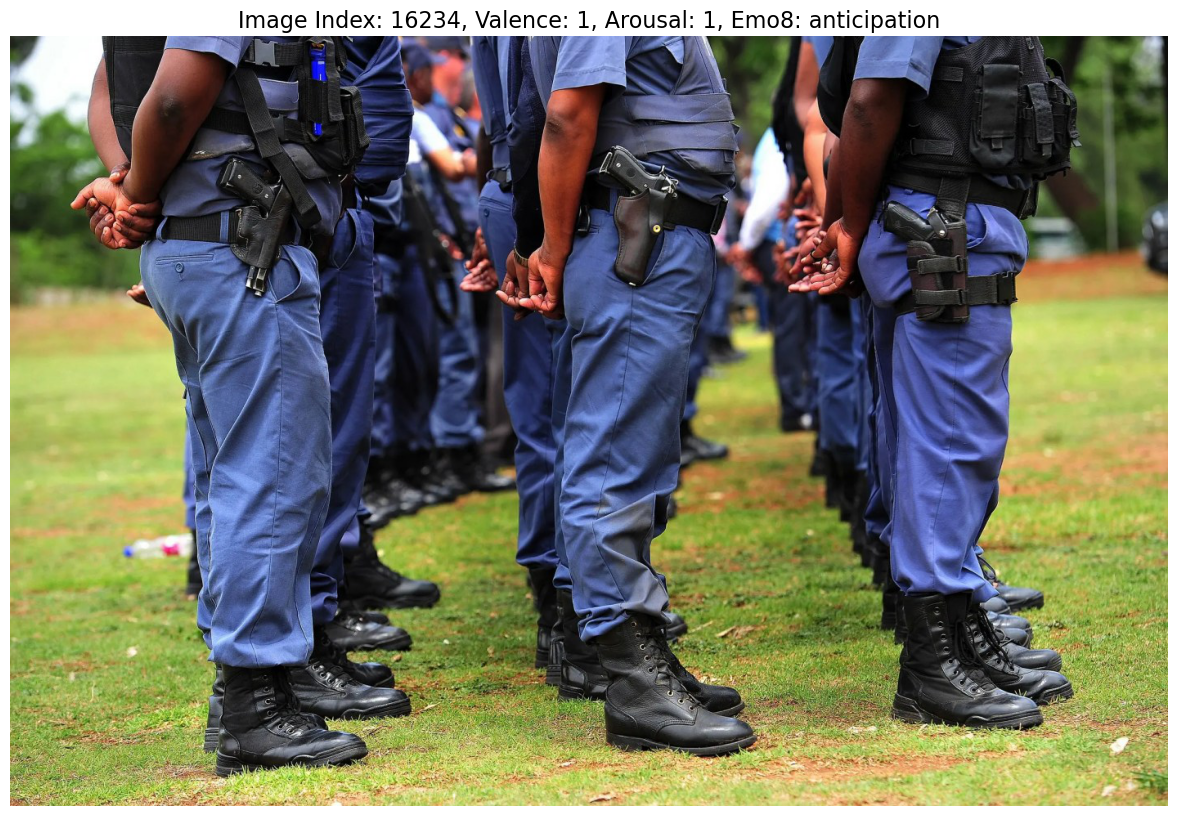

Base model (365 categories):
  baseball_field: 0.2692
  stadium_football: 0.1337
  golf_course: 0.1163

Mapped model (20 categories):
  comforting_social_outdoors: 0.4364
  high_energy_nature_leisure: 0.3885
  calm_everyday_interiors: 0.1254


In [116]:
# pick random element from train_indices
random_sample = random.choice(train_indices)
show_pretrained_model_predictions_on_sample(random_sample)

In [117]:
def show_images_with_context(context = None, threshold = 0.10, indices = train_indices, max_images=10):
    found_with_context = 0
    random.shuffle(indices)
    print(len(indices))
    for sample_idx in indices:
        scene_tensor = train_scenes_dataset[(sample_idx,)]

        with torch.no_grad():
            mapped_output = scene_model(scene_tensor.unsqueeze(0).to(DEVICE))[0]

        top3_mapped = torch.topk(mapped_output, 3)
        top3_categories = [mapped_categories[idx.item()] for idx in top3_mapped.indices.cpu()]

        # The probability of the context in the top 3 needs to exceed 10%
        top3_probs = torch.softmax(mapped_output, dim=0)[top3_mapped.indices]
        context_prob = 0
        if context in top3_categories:
            context_index = top3_categories.index(context)
            context_prob = top3_probs[context_index].item()

        if context is None or context_prob > threshold:
            show_pretrained_model_predictions_on_sample(sample_idx)
            found_with_context += 1
            if found_with_context >= max_images:
                    break

In [118]:
# debug_indices = [idx for idx in train_indices if df.loc[idx, 'nr_faces'] == 0]
# show_images_with_context(context="agriculture", max_images=10)

In [119]:
from deepproblog.engines import ApproximateEngine

heuristic1 = ApproximateEngine.ucs
heuristic2 = ApproximateEngine.geometric_mean

model = Model(os.path.join(prolog_dir, "model4v5.pl"), [face_network, scene_network])
model.set_engine(ApproximateEngine(model, 10, heuristic2))
# model.set_engine(ExactEngine(model), cache=True)
model.optimizer = SGD(model, lr_model)
model.train()

In [120]:
model.add_tensor_source("faces_train", train_faces_dataset)
model.add_tensor_source("faces_test", test_faces_dataset)

model.add_tensor_source("scenes_train", train_scenes_dataset)
model.add_tensor_source("scenes_test", test_scenes_dataset)

In [121]:
class FindingEmoDataset(DPLDataset):
    def __init__(self, indices, dataset_name):
        super(FindingEmoDataset, self).__init__()
        self.indices = indices
        self.dataset_name = dataset_name
    
    def __getitem__(self, i):
        pass
    
    def __len__(self):
        return len(self.indices)
    
    def to_query(self, i):
        index = self.indices[i]
        row = df.loc[index]
        nr_faces = row['nr_faces']
        sub_images = [Term("face_{}".format(x)) for x in range(nr_faces)]
        images = [
            Term("tensor", Term(f"faces_{self.dataset_name}", Constant(index), Constant(x))) for x in range(nr_faces)
        ]

        sub = {sub_images[x]: images[x] for x in range(nr_faces)}
        return Query(
            Term(f"final_emotion_{nr_faces}",
                 list2term(sub_images),
                 Term("tensor", Term(f"scenes_{self.dataset_name}", Constant(index))),
                 Term(row['emo8'])
            ),
            substitution=sub,
        )
    
train_dataset = FindingEmoDataset(train_indices, "train")
test_dataset = FindingEmoDataset(test_indices, "test")

In [122]:
def test_query(query, model):
    results = model.solve([query])
    result = results[0].result
    print(result)

In [123]:
train_loader = DPLDataLoader(train_dataset, batch_size=batch_size)

In [124]:
face_model.train()
scene_model.train()

print("Models put in train mode")

Models put in train mode


In [125]:
if load_model:
    model.load_state(os.path.join(model_dir, "model4_2_findingemo.zip"))

else:
    train_obj = train_model(
        model,
        train_loader,
        30,
        log_iter=log_iter
    )

    # save the model
    # model.save_state(os.path.join(model_dir, "model4v4.zip"))

Training  for 30 epoch(s)
Epoch 1
Iteration:  2 	s:6.7790 	Average Loss:  0.2466771010076627
0.4438129097285075	0.10023221166859153	0.4126759165268161	0.017032297037697597	0.19848593563505135	0.1451970979989744	0.3188681463758136	0.8551431806258477	0.11652123154175587	0.3629716924920434	0.6008844537351938	0.07289449058761677	0.39319830179266313	0.7019423415971315	0.7734087605294726	0.5325833146655897	0.9917368463016211	0.9549165400365879	0.39619678124978974	0.803948356424017
Iteration:  4 	s:9.0068 	Average Loss:  0.590275691007264
0.4450133413953101	0.10223491562585119	0.41344605009758406	0.023654855962998433	0.20039978949783988	0.14779175268013545	0.3239900212316449	0.8589074559708677	0.12254948908497698	0.3731677333421761	0.6048439954098972	0.10689936138978084	0.40307575721345523	0.7151808652182436	0.81680665838392	0.5451221193382482	1.0	0.9675312093148519	0.41649200214266613	0.8375806926083994
Epoch time:  19.18426823616028
Epoch 2
Iteration:  6 	s:8.6038 	Average Loss:  0.56864961

In [ ]:
from deepproblog.evaluate import get_confusion_matrix

get_confusion_matrix(model, test_dataset, verbose=1)

         	            	   	       	Actual	     	            	       
         	            	joy	sadness	  fear	trust	anticipation	disgust
         	         joy	  0	      0	     0	    0	           0	      0
         	     sadness	  6	      1	     8	    7	           6	      1
Predicted	        fear	  0	      0	     0	    0	           0	      0
         	       trust	  0	      0	     0	    0	           0	      0
         	anticipation	  0	      0	     0	    0	           0	      0
         	     disgust	  0	      0	     0	    0	           0	      0
Accuracy:  0.034482758620689655
Accuracy 0.034482758620689655


{final_emotion_0([],tensor(scenes_train(18312)),sadness): tensor(0.8741, device='cuda:0', grad_fn=<AddBackward0>), final_emotion_0([],tensor(scenes_train(18312)),fear): tensor(0.8741, device='cuda:0', grad_fn=<AddBackward0>), final_emotion_0([],tensor(scenes_train(18312)),joy): tensor(0.3660, device='cuda:0', grad_fn=<MulBackward0>), final_emotion_0([],tensor(scenes_train(18312)),trust): tensor(0.3660, device='cuda:0', grad_fn=<MulBackward0>), final_emotion_0([],tensor(scenes_train(18312)),surprise): tensor(0.7492, device='cuda:0', grad_fn=<MulBackward0>), final_emotion_0([],tensor(scenes_train(18312)),disgust): tensor(0.8042, device='cuda:0', grad_fn=<MulBackward0>), final_emotion_0([],tensor(scenes_train(18312)),anticipation): tensor(0.8134, device='cuda:0', grad_fn=<SelectBackward0>), final_emotion_0([],tensor(scenes_train(18312)),anger): tensor(0.8134, device='cuda:0', grad_fn=<SelectBackward0>)}


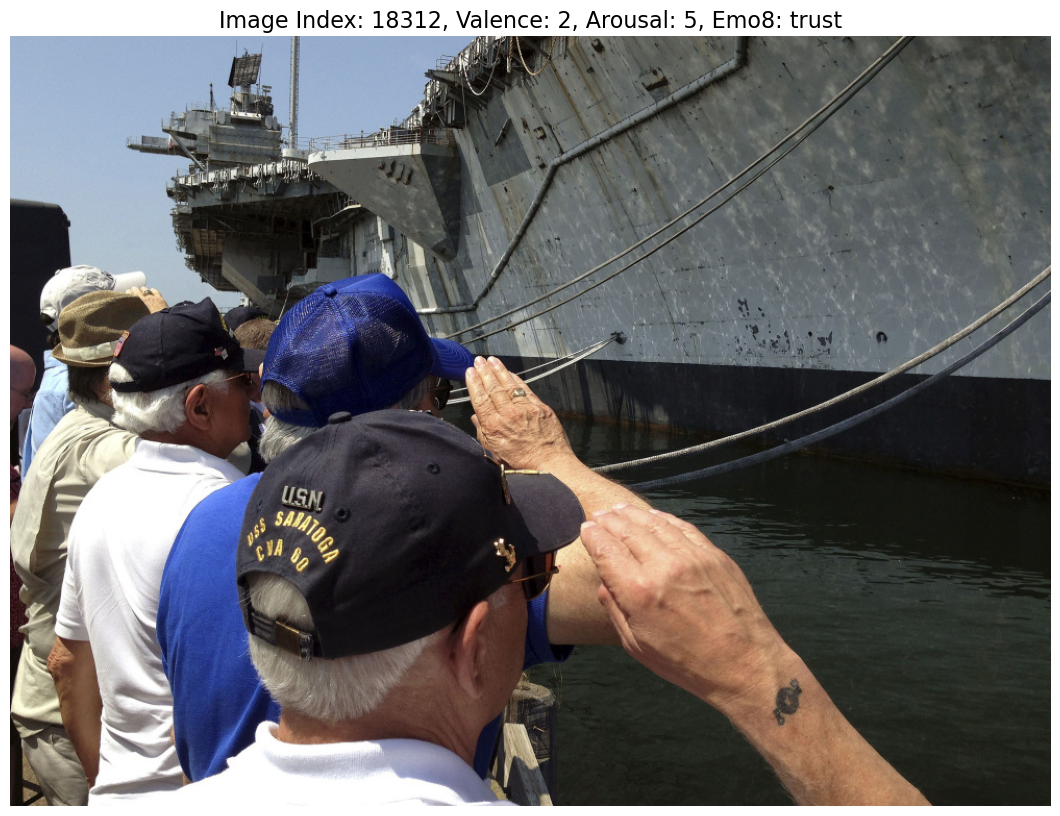

Base model (365 categories):
  lock_chamber: 0.8028
  dam: 0.0550
  moat_water: 0.0249

Mapped model (20 categories):
  urban_strain_discomfort: 0.8134
  lively_social_gathering_places: 0.0607
  peaceful_natural_retreats: 0.0550


In [ ]:
index = random.choice(train_indices)
row = df.loc[index]
nr_faces = row['nr_faces']
sub_images = [Term("face_{}".format(x)) for x in range(nr_faces)]
images = [
    Term("tensor", Term("faces_train", Constant(index), Constant(x))) for x in range(nr_faces)
]

sub = {sub_images[x]: images[x] for x in range(nr_faces)}
query = Query(
    Term(f"final_emotion_{nr_faces}",
            list2term(sub_images),
            Term("tensor", Term(f"scenes_train", Constant(index))),
            # Term(row['emo8'])
            Var("E")
    ),
    substitution=sub,
)
test_query(query, model)
show_pretrained_model_predictions_on_sample(index)


In [129]:
# if load_model:
#     model.load_state(os.path.join(model_dir, "model4_2_findingemo.zip"))

In [130]:
# get_confusion_matrix(model, test_dataset, verbose=1)